In [1]:
from tensorflow import keras
import tensorflow as tf
from keras import backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.prepareDataAttention import *

In [2]:
# 指定GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


2022-06-06 10:38:14.318222: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 10:38:14.330465: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 10:38:14.330734: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 10:38:14.332427: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [3]:
def attention(latent_dim):
    input_train = keras.layers.Input(shape=(20, 42, 1))
    # 第一CNN层
    conv_first1 = keras.layers.Conv2D(32, (1, 2), strides=(1, 2))(input_train)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = keras.layers.Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = keras.layers.Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    # 第二CNN层
    conv_first1 = keras.layers.Conv2D(32, (1, 2), strides=(1, 2))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = keras.layers.Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = keras.layers.Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    # 第三CNN层
    conv_first1 = keras.layers.Conv2D(32, (1, 10))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = keras.layers.Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = keras.layers.Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    # 通道一
    convsecond_1 = keras.layers.Conv2D(64, (1, 1), padding='same')(conv_first1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = keras.layers.Conv2D(64, (3, 1), padding='same')(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    # 通道二
    convsecond_2 = keras.layers.Conv2D(64, (1, 1), padding='same')(conv_first1)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = keras.layers.Conv2D(64, (5, 1), padding='same')(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    # 通道三
    convsecond_3 = keras.layers.MaxPooling2D((3, 1), strides=(1, 1), padding='same')(conv_first1)
    convsecond_3 = keras.layers.Conv2D(64, (1, 1), padding='same')(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)

    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = keras.layers.Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(
        convsecond_output)

    # Encoder：由LSTM担任
    encoder_inputs = conv_reshape
    encoder = keras.layers.LSTM(latent_dim, return_state=True, return_sequences=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    states = [state_h, state_c]

    # Decoder：依然使用LSTM，每一次只处理一个时间步
    decoder_inputs = keras.layers.Input(shape=(1, 3))
    decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_dense = keras.layers.Dense(3, activation='softmax', name='output_layer')

    all_outputs = []
    all_attention = []

    encoder_state_h = keras.layers.Reshape((1, int(state_h.shape[1])))(state_h)
    inputs = keras.layers.concatenate([decoder_inputs, encoder_state_h], axis=2)
    # Decoder同时输出5个预测范围下的结果，循环使用5个Decoder
    for _ in range(5):
        outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)
        # 做dot得到Attention
        attention = keras.layers.dot([outputs, encoder_outputs], axes=2)
        attention = keras.layers.Activation('softmax')(attention)
        # 得到context vector
        context = keras.layers.dot([attention, encoder_outputs], axes=[2, 1])
        context = keras.layers.BatchNormalization(momentum=0.6)(context)

        # Decoder的Input
        decoder_combined_context = keras.layers.concatenate([context, outputs])
        # 得到Decoder的输出
        outputs = decoder_dense(decoder_combined_context)
        all_outputs.append(outputs)
        all_attention.append(attention)

        inputs = keras.layers.concatenate([outputs, context], axis=2)
        states = [state_h, state_c]

    # decoder_attention = keras.layers.Lambda(lambda x: K.concatenate(x, axis=1), name='attentions')(all_attention)
    # 综合5个Decoder的输出作为最终模型的输出
    decoder_outputs = keras.layers.Lambda(lambda x: K.concatenate(x, axis=1), name='outputs')(all_outputs)
    # 定义模型
    model = keras.models.Model([input_train, decoder_inputs], decoder_outputs)
    return model

In [4]:
T = 20
epochs = 50
batch_size = 32
n_hidden = 64
stockIndex = 1
checkpoint_filepath = f'./attentionWeights/stock{stockIndex}_final_42_y_{T}T'

In [5]:
dec_train = pd.read_csv(f'../../data/processed/stock{stockIndex}/final_train7_part{stockIndex}.csv')
dec_test1 = pd.read_csv(f'../../data/processed/stock{stockIndex}/final_test7_part{stockIndex}.csv')
dec_test2 = pd.read_csv(f'../../data/processed/stock{stockIndex}/final_test8_part{stockIndex}.csv')
dec_test3 = pd.read_csv(f'../../data/processed/stock{stockIndex}/final_test9_part{stockIndex}.csv')
frames = [dec_test1, dec_test2, dec_test3]
dec_test = pd.concat(frames)

# 指定使用源数据中的42个特征
train_lob = prepare_x(dec_train, num_features=42)
test_lob = prepare_x(dec_test, num_features=42)

# 指定预测标签
train_label = get_label(np.array(dec_train))
test_label = get_label(np.array(dec_test))

# 准备好Encoder和Decoder的训练输入和groundTruth
train_encoder_input, train_decoder_target = data_classification(train_lob, train_label, T)
train_decoder_input = prepare_decoder_input(train_encoder_input, teacher_forcing=False)

test_encoder_input, test_decoder_target = data_classification(test_lob, test_label, T)
test_decoder_input = prepare_decoder_input(test_encoder_input, teacher_forcing=False)

print(f'train_encoder_input.shape = {train_encoder_input.shape},'
      f'train_decoder_target.shape = {train_decoder_target.shape}')
print(f'test_encoder_input.shape = {test_encoder_input.shape},'
      f'test_decoder_target.shape = {test_decoder_target.shape}')

train_encoder_input.shape = (50931, 20, 42, 1),train_decoder_target.shape = (50931, 5, 3)
test_encoder_input.shape = (28558, 20, 42, 1),test_decoder_target.shape = (28558, 5, 3)


In [6]:
model = attention(n_hidden)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [7]:
split_train_val = int(np.floor(len(train_encoder_input) * 0.8))

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

model.fit([train_encoder_input[:split_train_val], train_decoder_input[:split_train_val]], 
          train_decoder_target[:split_train_val],
          validation_data=([train_encoder_input[split_train_val:], train_decoder_input[split_train_val:]], 
          train_decoder_target[split_train_val:]),
          epochs=epochs, batch_size=batch_size, verbose=2, callbacks=[model_checkpoint_callback])

Epoch 1/50


2022-06-06 10:38:50.774062: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA RTX A4000" frequency: 1560 num_cores: 48 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 102400 memory_size: 14950137856 bandwidth: 448064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-06-06 10:38:50.775294: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA RTX A4000" frequency

1274/1274 - 61s - loss: 1.0314 - accuracy: 0.4542 - val_loss: 1.0938 - val_accuracy: 0.3833 - 61s/epoch - 48ms/step
Epoch 2/50
1274/1274 - 44s - loss: 0.9042 - accuracy: 0.5727 - val_loss: 0.8625 - val_accuracy: 0.6089 - 44s/epoch - 35ms/step
Epoch 3/50
1274/1274 - 46s - loss: 0.7612 - accuracy: 0.6751 - val_loss: 0.7872 - val_accuracy: 0.6793 - 46s/epoch - 36ms/step
Epoch 4/50
1274/1274 - 45s - loss: 0.6734 - accuracy: 0.7238 - val_loss: 0.6840 - val_accuracy: 0.7184 - 45s/epoch - 35ms/step
Epoch 5/50
1274/1274 - 44s - loss: 0.6341 - accuracy: 0.7434 - val_loss: 0.6504 - val_accuracy: 0.7361 - 44s/epoch - 35ms/step
Epoch 6/50
1274/1274 - 45s - loss: 0.6132 - accuracy: 0.7521 - val_loss: 0.6270 - val_accuracy: 0.7429 - 45s/epoch - 35ms/step
Epoch 7/50
1274/1274 - 42s - loss: 0.5948 - accuracy: 0.7606 - val_loss: 0.6957 - val_accuracy: 0.7224 - 42s/epoch - 33ms/step
Epoch 8/50
1274/1274 - 44s - loss: 0.5801 - accuracy: 0.7671 - val_loss: 0.6234 - val_accuracy: 0.7475 - 44s/epoch - 35ms/

In [8]:
model.load_weights(checkpoint_filepath)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 42, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 20, 21, 32)   96          ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 20, 21, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 20, 21, 32)   4128        ['leaky_re_lu[0][0]']            
                                                                                              

In [9]:
pred = model.predict([test_encoder_input, test_decoder_input])
evaluation_metrics(test_decoder_target, pred)

2022-06-06 11:17:25.950351: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA RTX A4000" frequency: 1560 num_cores: 48 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 102400 memory_size: 14950137856 bandwidth: 448064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-06-06 11:17:25.950812: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA RTX A4000" frequency

Prediction horizon = 0
accuracy_score = 0.8432663351775335
classification_report =               precision    recall  f1-score   support

           0     0.9046    0.5163    0.6574      4573
           1     0.8507    0.9585    0.9014     19839
           2     0.7527    0.6527    0.6991      4146

    accuracy                         0.8433     28558
   macro avg     0.8360    0.7091    0.7526     28558
weighted avg     0.8451    0.8433    0.8329     28558

-------------------------------
Prediction horizon = 1
accuracy_score = 0.7583164087120947
classification_report =               precision    recall  f1-score   support

           0     0.8701    0.4049    0.5527      5907
           1     0.7553    0.9450    0.8396     17384
           2     0.6989    0.5384    0.6083      5267

    accuracy                         0.7583     28558
   macro avg     0.7748    0.6295    0.6668     28558
weighted avg     0.7686    0.7583    0.7376     28558

-------------------------------
Predicti

# 针对不同时间步的attention权重实验

In [52]:
model = keras.models.Model(inputs=model.input,
              outputs=[model.output, model.get_layer('activation_10').output, model.get_layer('activation_11').output, model.get_layer('activation_12').output, model.get_layer('activation_13').output, model.get_layer('activation_14').output])

In [53]:
# model.load_weights(checkpoint_filepath)
outputs = model.predict([test_encoder_input, test_decoder_input])
pred = outputs[0]
# attention1是k=10时，attention5是k=30时
attention1 = outputs[1]
attention2 = outputs[2]
attention3 = outputs[3]
attention4 = outputs[4]
attention5 = outputs[5]

2022-06-04 14:42:33.189805: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA RTX A4000" frequency: 1560 num_cores: 48 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 102400 memory_size: 12453478400 bandwidth: 448064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-06-04 14:42:33.190221: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA RTX A4000" frequency

In [54]:
print(attention1[0][0])
# attention[0]中的排序方式为：第一时间步、第二时间步。。。

[0.01078201 0.01074526 0.00638794 0.00416656 0.00330497 0.00224654
 0.00211841 0.00248389 0.00406273 0.0056353  0.00857462 0.01496092
 0.02481331 0.03352311 0.04155738 0.05759889 0.09970216 0.16343136
 0.23426698 0.26963764]


In [55]:
# 得到attention矩阵
array1,array2,array3,array4,array5 = np.array(attention1[0][0]),np.array(attention2[0][0]),np.array(attention3[0][0]),np.array(attention4[0][0]),np.array(attention5[0][0])
attention_matrix = np.stack((array1,array2,array3,array4,array5),axis=0)
attention_matrix

array([[0.01078201, 0.01074526, 0.00638794, 0.00416656, 0.00330497,
        0.00224654, 0.00211841, 0.00248389, 0.00406273, 0.0056353 ,
        0.00857462, 0.01496092, 0.02481331, 0.03352311, 0.04155738,
        0.05759889, 0.09970216, 0.16343136, 0.23426698, 0.26963764],
       [0.01654554, 0.01434477, 0.00895939, 0.00625188, 0.00565409,
        0.00459414, 0.00504766, 0.00658041, 0.01078756, 0.01434906,
        0.02167361, 0.03733276, 0.0578718 , 0.07327807, 0.08661943,
        0.10715756, 0.13552585, 0.14669506, 0.12633039, 0.11440093],
       [0.01261244, 0.00906536, 0.0074229 , 0.00688024, 0.00760894,
        0.00841871, 0.0115451 , 0.01710195, 0.02794451, 0.03668655,
        0.05037608, 0.0708454 , 0.08892323, 0.10353905, 0.11773416,
        0.12543571, 0.11303692, 0.08553535, 0.05444882, 0.04483857],
       [0.00970477, 0.00638762, 0.0059907 , 0.00632423, 0.00756557,
        0.01015535, 0.01609576, 0.02636916, 0.04399814, 0.05643775,
        0.07714269, 0.09945808, 0.10515121, 0

In [56]:
np.savetxt(f'./attentionWeights/stock{stockIndex}_final_42_y_{T}T',attention_matrix)
matrix = np.loadtxt(f'./attentionWeights/stock{stockIndex}_final_42_y_{T}T')
matrix

array([[0.01078201, 0.01074526, 0.00638794, 0.00416656, 0.00330497,
        0.00224654, 0.00211841, 0.00248389, 0.00406273, 0.0056353 ,
        0.00857462, 0.01496092, 0.02481331, 0.03352311, 0.04155738,
        0.05759889, 0.09970216, 0.16343136, 0.23426698, 0.26963764],
       [0.01654554, 0.01434477, 0.00895939, 0.00625188, 0.00565409,
        0.00459414, 0.00504766, 0.00658041, 0.01078756, 0.01434906,
        0.02167361, 0.03733276, 0.0578718 , 0.07327807, 0.08661943,
        0.10715756, 0.13552585, 0.14669506, 0.12633039, 0.11440093],
       [0.01261244, 0.00906536, 0.0074229 , 0.00688024, 0.00760894,
        0.00841871, 0.0115451 , 0.01710195, 0.02794451, 0.03668655,
        0.05037608, 0.0708454 , 0.08892323, 0.10353905, 0.11773416,
        0.12543571, 0.11303692, 0.08553535, 0.05444882, 0.04483857],
       [0.00970477, 0.00638762, 0.0059907 , 0.00632423, 0.00756557,
        0.01015535, 0.01609576, 0.02636916, 0.04399814, 0.05643775,
        0.07714269, 0.09945808, 0.10515121, 0

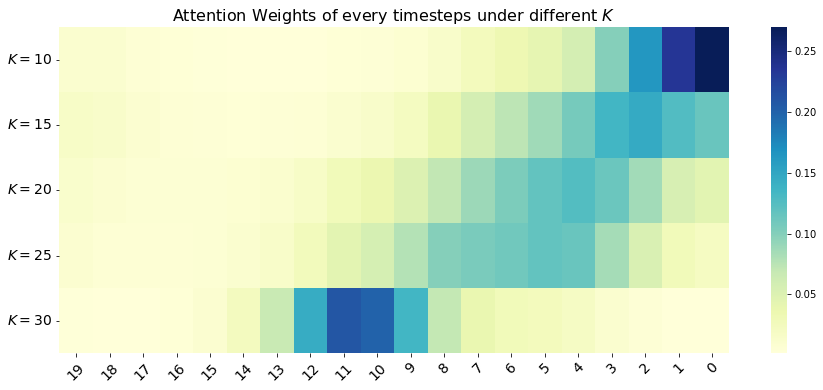

In [57]:
%matplotlib inline
import seaborn as sns

# fig, axes = plt.subplots()
plt.figure(figsize=(15,6))
# df_cm = pd.DataFrame(attention_matrix, index=['$K=10$','$K=15$','$K=20$','$K=25$','$K=30$'], columns=['$H_{t-49}$','$H_{t-48}$','$H_{t-47}$','$H_{t-46}$','$H_{t-45}$','$H_{t-44}$','$H_{t-43}$','$H_{t-42}$','$H_{t-41}$','$H_{t-40}$','$H_{t-39}$','$H_{t-38}$','$H_{t-37}$','$H_{t-36}$','$H_{t-35}$','$H_{t-34}$','$H_{t-33}$','$H_{t-32}$','$H_{t-31}$','$H_{t-30}$','$H_{t-29}$','$H_{t-28}$','$H_{t-27}$','$H_{t-26}$','$H_{t-25}$','$H_{t-24}$','$H_{t-23}$','$H_{t-22}$','$H_{t-21}$','$H_{t-20}$','$H_{t-19}$','$H_{t-18}$','$H_{t-17}$','$H_{t-16}$','$H_{t-15}$','$H_{t-14}$','$H_{t-13}$','$H_{t-12}$','$H_{t-11}$','$H_{t-10}$','$H_{t-9}$','$H_{t-8}$','$H_{t-7}$','$H_{t-6}$','$H_{t-5}$','$H_{t-4}$','$H_{t-3}$','$H_{t-2}$','$H_{t-1}$','$H_{t}$'])
# df_cm = pd.DataFrame(attention_matrix, index=['$K=10$','$K=15$','$K=20$','$K=25$','$K=30$'], columns=['49','48','47','46','45','44','43','42','41','40','39','38','37','36','35','34','33','32','31','30','29','28','27','26','25','24','23','22','21','20','19','18','17','16','15','14','13','12','11','10','9','8','7','6','5','4','3','2','1','0'])
df_cm = pd.DataFrame(attention_matrix, index=['$K=10$','$K=15$','$K=20$','$K=25$','$K=30$'], columns=['19','18','17','16','15','14','13','12','11','10','9','8','7','6','5','4','3','2','1','0'])
heatmap = sns.heatmap(df_cm,annot=False, cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0,fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, fontsize=14)
plt.title("Attention Weights of every timesteps under different $K$", fontsize=16)
# axes.set_ylabel("true label")
# axes.set_xlabel("predict label")
plt.show()